In [1]:
!pip install svetlanna
!pip install reservoirpy matplotlib tqdm requests av scikit-image py-cpuinfo gputil pandas


[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import time

import numpy as np
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
from tqdm import tqdm
import matplotlib.pyplot as plt

# наша библиотека
from svetlanna import SimulationParameters
from svetlanna.parameters import ConstrainedParameter
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna.setup import LinearOpticalSetup
from svetlanna.detector import Detector, DetectorProcessorClf
from svetlanna.transforms import ToWavefront

from src.wf_datasets import DatasetOfWavefronts
from src.wf_datasets import WavefrontsDatasetSimple

# Решение прямой задачи дифракции с использованием графического процессора 

В данном примере решена прямая задача дифракции с использованием графического процессора.

**<span style="color:red">ПРЕДУПРЕЖДЕНИЕ.</span>** для запуска этого примера необходимо установить с [официального сайта](https://pytorch.org/get-started/locally/) версию `torch`, поддерживающую вычисления на CUDA.

Также с [официального сайта NVIDIA](https://developer.nvidia.com/cuda-toolkit) необходимо установить драйвера CUDA. 

**<span style="color:red">ВАЖНО:</span>** версия torch с поддержкой CUDA и версия драйверов CUDA должны совпадать. Версия драйверов CUDA зависит от видеокарты, на которой планируется запуск примера.

# Информация об архитектуре оптической нейронной сети

В этом примере реализована простая оптическая система, которая может быть использована в качестве архитектуры для дифракционной нейронной сети. 

> В общем случае фаза и амплитуда каждого нейрона могут быть изучаемыми параметрами, обеспечивая комплекснозначную модуляцию на каждом слое, что улучшает производительность вывода дифракционной сети.

> ... Сначала мы обучили его как классификатор цифр для автоматической классификации рукописных цифр от 0 до 9. Для этой задачи были разработаны маски пропускания, учитывающие только фазу, путём обучения **пятислойной** нейронной сети $D^2 на 55 000 изображений (из них 5000 проверочных) из базы данных рукописных цифр MNIST.

>  Затем мы использовали непрерывное освещение на частоте $0,4$ $ТГц$...


Некоторая информация из [дополнительного материала](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) (информация о классификации MNIST):

> Поскольку мы рассматриваем когерентное освещение, входная информация может быть закодирована в амплитудных и/или фазовых каналах входной плоскости.

> Для каждого слоя $D^2NN$ мы устанавливаем размер нейрона равным $400$ $\mu m$...

> На плоскости детектор/выход мы измерили интенсивность выхода сети...

#### <span style="color:red">Дополнительная информация</span>

В другой статье [[2]](https://ieeexplore.ieee.org/abstract/document/8732486) тех же авторов были уточнены некоторые детали:

> В наших численных моделях мы использовали размер нейрона приблизительно $0,53 \times \lambda $

>  Кроме того, высота и ширина каждого дифракционного слоя были установлены таким образом, чтобы включать $200 \times 200 = 40 тыс.$ нейронов на слой.

# 1. Параметры симуляции

In [3]:
working_frequency = 0.4 * 1e12 # [Гц]
c_const = 299_792_458  # [м / с]

In [4]:
working_wavelength = c_const / working_frequency  # [м]
print(f'Длина волны = {working_wavelength * 1e6:.3f} нм')

Длина волны = 749.481 нм


In [5]:
# размер нейрона
neuron_size = 0.53 * working_wavelength  # [m]
print(f'neuron size = {neuron_size * 1e6:.3f} um')

neuron size = 397.225 um


In [6]:
DETECTOR_SIZE = (32, 32)

In [7]:
# количество нейронов в симуляции
x_layer_nodes = DETECTOR_SIZE[1] * 1
y_layer_nodes = DETECTOR_SIZE[0] * 1

print(f'Размер слоя в нейронах: {x_layer_nodes} x {y_layer_nodes} = {x_layer_nodes * y_layer_nodes}')

Размер слоя в нейронах: 32 x 32 = 1024


In [8]:
# физический размер каждого слоя - (8 x 8) [см]
x_layer_size_m = x_layer_nodes * neuron_size  # [м]
y_layer_size_m = y_layer_nodes * neuron_size

print(f'Размер слоя в сантиметрах: {x_layer_size_m * 1e2} x {y_layer_size_m * 1e2}')

Размер слоя в сантиметрах: 1.27112002192 x 1.27112002192


In [9]:
SIM_PARAMS = SimulationParameters(
    axes={
        'W': torch.linspace(-x_layer_size_m / 2, x_layer_size_m / 2, x_layer_nodes),
        'H': torch.linspace(-y_layer_size_m / 2, y_layer_size_m / 2, y_layer_nodes),
        'wavelength': working_wavelength,  # only one wavelength!
    }
)

# 2. Подготовка выборки данных (Инженер данных)

## 2.1. [Выборка данных MNIST](https://www.kaggle.com/datasets/hojjatk/mnist-dataset): загрузка и преобразование в волновые фронты

In [10]:
# инициализация директории для набора данных MNIST
MNIST_DATA_FOLDER = './data'

### 2.1.1. Загрузка тренировочной и тестовой выборок изображений

In [11]:
# тренировочный набор MNIST
mnist_train_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=True,  # для тренировочного набора
    download=True,
)

In [12]:
print(f'Размер тренировочой выборки: {len(mnist_train_ds)}')

Размер тренировочой выборки: 60000


### 2.1.2. Детектор

`DetectorProcessor` в нашей библиотеке используется для обработки информации на детекторе. Например, для текущей задачи `DetectorProcessor` должен возвращать только 10 значений, каждое из которых соответствует определенной цифре.

 Определим объект типа “Detector”

In [13]:
import src.detector_segmentation as detector_segmentation

In [14]:
number_of_classes = 10

In [15]:
detector_segment_size = 10 * working_wavelength

In [16]:
# размер каждого сегмента в нейронах
x_segment_nodes = int(detector_segment_size / neuron_size)
y_segment_nodes = int(detector_segment_size / neuron_size)

In [17]:
y_boundary_nodes = y_segment_nodes * 9
x_boundary_nodes = x_segment_nodes * 9

In [18]:
DETECTOR_MASK = detector_segmentation.squares_mnist(
    y_boundary_nodes, x_boundary_nodes,
    SIM_PARAMS
)

**<span style="color:red">Комментарий:</span>** Эта маска будет использована для генерации целевых изображений для каждой цифры

<span style="color:red">Целевое изображение:</span> нули везде кроме нужной зоны детектора! 

### 2.1.3. Преобразование изображений в волновые фронты

In [19]:
# выбор типа модуляции
MODULATION_TYPE = 'amp'  # используем только амплитуду для кодирования каждого изображения в волновом фронте!

In [20]:
resize_y = int(DETECTOR_SIZE[0] / 3)
resize_x = int(DETECTOR_SIZE[1] / 3)

# отсутпы по OY
pad_top = int((y_layer_nodes - resize_y) / 2)
pad_bottom = y_layer_nodes - pad_top - resize_y
# отсутпы по OX
pad_left = int((x_layer_nodes - resize_x) / 2)
pad_right = x_layer_nodes - pad_left - resize_x

In [21]:
# преобразование изображений в волновой фронт
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # левый отступ
              pad_top,  # верхний отступ
              pad_right,  # правый отступ
              pad_bottom  # нижний отступ
          ),
          fill=0,
      ),
      ToWavefront(modulation_type=MODULATION_TYPE)  # <- выбранный тип модуляции!!!
  ]
)

**<span style="color:red">Комментарий.</span>** в этой части кода`dataset.getitem()` вернет пару `Wavefront`, в котором закодировано само изображений цифры, и целевую метку(число от 0 до 9). В течение процесса тренировки в качестве функции потерь будет использована функция среднеквадратической ошибки,также будет сгенерировано изображение детектора цели на основе зон детектора (будет инициализировано позже в 3.1.3).

In [22]:
# тренировочный набор волновых фронтов MNIST
mnist_wf_train_ds = DatasetOfWavefronts(
    init_ds=mnist_train_ds,  # выборка изображений
    transformations=image_transform_for_ds,  # преобразование изображений
    sim_params=SIM_PARAMS,  # параметры симуляции
    target='detector',
    detector_mask=DETECTOR_MASK
)

# 3. Создание архитектуры оптической нейронной сети

Будет рассмотрена архитектура оптической нейронной сети, состоящая из нескольких дифракционных слоев, преобразующих фазовое распределение падающего волнового фронта. Несколько масок будут подвержены обучению.

#### <span style="color:red">Дополнительная информация</span>

Из статьи [[2]](https://ieeexplore.ieee.org/abstract/document/8732486):

> ... аксиальное расстояние между последовательными дифракционными слоями устанавливается равным $\sim 40 \times \lambda$ as in [[1]](https://www.science.org/doi/10.1126/science.aat8084) ...

## 3.1 Инициализация параметров для создания архитектуры дифракционной нейронной сети

In [23]:
NUM_OF_DIFF_LAYERS = 5  # число обучаемых дифракционных слоев в оптической нейронной сети
NUM_OF_DIFF_LAYERS_NO_TRAIN = 507 # число дифракционных слоев в оптической нейронной сети без обучения
FREE_SPACE_DISTANCE = 40 * working_wavelength  # [m] - растояние между дифракционными слоями

In [24]:
print(f'Расстояние между дифракционными слоями равно {FREE_SPACE_DISTANCE * 1e2:.3f} cm')

Расстояние между дифракционными слоями равно 2.998 cm


In [25]:
MAX_PHASE = 2 * np.pi  # максимальный набег фазы для фазовых масок
INIT_PHASE = torch.pi # начальная фаза для слоев

**<span style="color:red">Отличие от статьи.</span>** используем другой метод распространения волн из модуля `FreeSpace`, отличный от метода из статьи [2]!

In [26]:
FREESPACE_METHOD = 'AS'

In [27]:
INIT_PHASES = torch.ones(NUM_OF_DIFF_LAYERS) * np.pi  # начальные значения фазовых масок

**<span style="color:red">Комментарий:</span>**
Здесь мы используем класс `ConstrainedParameter`, который использует функцию сигмоиды для ограничения параметров в ходе обучения.

**<span style="color:red">Комментарий:</span>** оптическая система заканчивается детектором `Detector`, который возвращает тензор выходных распределений интенсивности для каждого входного волнового фронта `Wavefront`.

## 3.2 Функции для создания архитектуры оптической нейронной сети

Инициализируем функцию, которая создает описанную ранее оптическую систему и возвращает объект типа `LinearOpticalSetup`:

In [ ]:
def set_setup():
    """
    Returns an optical setup. Recreates all elements.
    """

    global NUM_OF_DIFF_LAYERS, NUM_OF_DIFF_LAYERS_NO_TRAIN, FREE_SPACE_DISTANCE, SIM_PARAMS, FREESPACE_METHOD, INIT_PHASE
    global SIM_PARAMS

    elements_list = []

    free_space = elements.FreeSpace(
        simulation_parameters=SIM_PARAMS,
        distance=FREE_SPACE_DISTANCE,
        method=FREESPACE_METHOD
    )

    x_nodes, y_nodes = SIM_PARAMS.axes_size(axs=('W', 'H'))
    const_mask = torch.ones(size=(y_nodes, x_nodes)) * INIT_PHASE

    trainable_diffractive_layer = elements.DiffractiveLayer(
        simulation_parameters=SIM_PARAMS,
        mask=ConstrainedParameter(
            const_mask,
            min_value=0,
            max_value=MAX_PHASE
        ),
    )

    untrained_diffractive_layer = elements.DiffractiveLayer(
        simulation_parameters=SIM_PARAMS,
        mask=const_mask,  # Здесь мы не используем ConstrainedParameter, чтобы не ограничивать значения маски
    )

    elements_list.append(free_space)

    for _ in range(NUM_OF_DIFF_LAYERS):
        elements_list.append(trainable_diffractive_layer)
        elements_list.append(free_space)
    for _ in range(NUM_OF_DIFF_LAYERS_NO_TRAIN):
        elements_list.append(untrained_diffractive_layer)
        elements_list.append(free_space)

     # Добавляем детектор в конце оптической системы
    elements_list.append(
        Detector(
            simulation_parameters=SIM_PARAMS,
            func='intensity'  # детектор возвращает интенсивность
        )
    )

    return LinearOpticalSetup(elements=elements_list)

## 4. Обработка детектором

`DetectorProcessor` в нашей библиотеке используется для обработки информации на детекторе. Например, для текущей задачи `DetectorProcessor` должен возвращать только 10 значений, каждое из которых соответствует определенной цифре.

In [32]:
CALCULATE_ACCURACIES = True

In [33]:
# создаем объект DetectorProcessorOzcanClf
if CALCULATE_ACCURACIES:
    detector_processor = DetectorProcessorClf(
        simulation_parameters=SIM_PARAMS,
        num_classes=number_of_classes,
        segmented_detector=DETECTOR_MASK,
    )
else:
    detector_processor = None

# 5. Подготовка к тренировки нейронной сети

## 5.1 Загрузка тренировочной выборки волновых фронтов

In [34]:
# выделяем тренировочный набор данных
train_wf_ds, _ = torch.utils.data.random_split(
    dataset=mnist_wf_train_ds,
    lengths=[55000, 5000],  # sizes from the article
    generator=torch.Generator().manual_seed(178)  # for reproducibility
)

## 5.2 Выбор метода оптимизации весов

In [35]:
LR = 1e-3

In [36]:
def get_adam_optimizer(net):
    return torch.optim.Adam(
        params=net.parameters(),  # NETWORK PARAMETERS!
        lr=LR
    )

**<span style="color:red">Комментарий:</span>** в качестве функции потерь используем значение среднеквадратической ошибки `MSELoss`

In [37]:
loss_func_clf = nn.MSELoss()
loss_func_name = 'MSE'

## 5.3 Прямое распространение через нейронную сеть(прямая задача дифракции)

In [39]:
def onn_forward(
    optical_net,
    wavefronts_dataloader,
    device='cpu',
    show_process=False
    ):
    """
    Performs network's forward for all data.
        NO DetectorProcessor
        NO Loss
    """
    optical_net.eval()  # включение режима оценки

    for batch_wavefronts, batch_labels in tqdm(
        wavefronts_dataloader,
        total=len(wavefronts_dataloader),
        desc='validation', position=0,
        leave=True, disable=not show_process
    ):

        batch_size = batch_wavefronts.size()[0]

        # пинование памяти для более быстрой передачи на GPU
        batch_wavefronts = batch_wavefronts.pin_memory().to(device, non_blocking=True)
        batch_labels = batch_labels.pin_memory().to(device, non_blocking=True)

        with torch.no_grad():
            # только прямое распространение!
            detector_output  = optical_net(batch_wavefronts)

# 6. Решения прямой задачи дифракции на различных вычислительных устройствах

## 6.1 Использование GPU

Для использования GPU необходимо, чтобы все обучаемые параметры, набор данный, сама нейронная сеть и параметры симуляции находились на одном вычислительном устройстве. Для переноса параметров симуляции и нейронной сети используется метод `to(<device>)` с указанием нужного устройства, доступного для использования.

В случае некорректного переноса появится ошибка, сообщающая о том, что какие-то из объектов располагаются на различных вычислительных устройствах.

In [ ]:
gpu_info = torch.cuda.get_device_properties(0) if torch.cuda.is_available() else None
if gpu_info:
    print(f"gpu name: {gpu_info.name}")
    print(f"gpu memory total: {gpu_info.total_memory / 1e9:.3f} GB")
    print(f"gpu compute capability: {gpu_info.major}.{gpu_info.minor}")
    print(f"gpu device count: {torch.cuda.device_count()}")

In [ ]:
DEVICE = "cuda"
optical_setup = set_setup()
net = optical_setup.net.to(DEVICE)
SIM_PARAMS = SIM_PARAMS.to(DEVICE)

params = [
    {
        'pin_memory': True,
        'drop_last': True,
    },
]


gpu_times = {}
batch_sizes = [128, 256, 512, 1024]

for i, param in enumerate(params):

    gpu_times_ = []

    gpu_times[i] = gpu_times_

    for bs in batch_sizes:
        train_loader = torch.utils.data.DataLoader(
            train_wf_ds,
            batch_size=bs,
            **param

        )

        start = time.process_time()
        onn_forward(
            net,
            train_loader,
            device='cuda',
            show_process=True,
        )
        gpu_times_.append(time.process_time() - start)
        # torch.cuda.empty_cache()

validation: 100%|██████████| 53/53 [00:56<00:00,  1.07s/it]


# 6.2 Использование CPU

In [42]:
DEVICE = "cpu"
optical_setup = set_setup()
net = optical_setup.net.to(DEVICE)
SIM_PARAMS = SIM_PARAMS.to(DEVICE)

params = [
    {
        'pin_memory': True,
        'drop_last': True,
    },
]

cpu_times = {}
batch_sizes = [128, 256, 512, 1024]

for i, param in enumerate(params):
    cpu_times_ = []

    cpu_times[i] = cpu_times_

    for bs in batch_sizes:
        train_loader = torch.utils.data.DataLoader(
            train_wf_ds,
            batch_size=bs,
            **param

        )

        start = time.process_time()
        onn_forward(
            net,  # optical network composed in 3.
            train_loader,  # dataloader of training set
            device='cpu',
            show_process=True,
        )
        cpu_times_.append(time.process_time() - start)

validation: 100%|██████████| 53/53 [03:59<00:00,  4.52s/it]


## 6.3 Сравнение GPU и CPU

Уже при небольших размерах расчетной сетки можно наблюдать ускорение в несколько раз при использовании gpu. Итоговое значение ускорение также зависит от выбранного для совершения вычислений устройства.

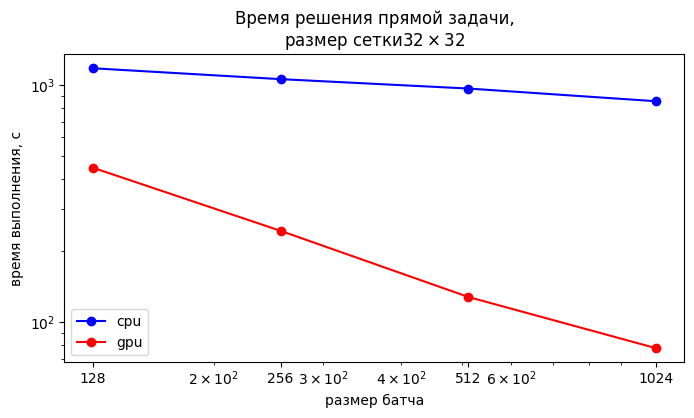

In [44]:
plt.figure(figsize=(8, 4))
plt.title('Время решения прямой задачи,\nразмер сетки' + rf"${DETECTOR_SIZE[0]}\times{DETECTOR_SIZE[1]}$")
plt.plot(batch_sizes, cpu_times[0], '-o', label='cpu', color="blue")
plt.plot(batch_sizes, gpu_times[0], '-o', label='gpu', color="red")
plt.yscale('log')
plt.xscale('log')
plt.xticks(batch_sizes,batch_sizes)
plt.xlabel('размер батча')
plt.ylabel('время выполнения, с')
plt.legend()


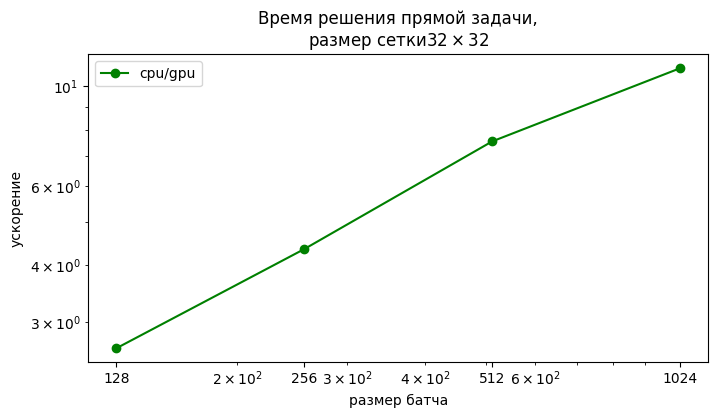

In [45]:
plt.figure(figsize=(8, 4))
plt.title('Время решения прямой задачи,\nразмер сетки' + rf"${DETECTOR_SIZE[0]}\times{DETECTOR_SIZE[1]}$")
plt.plot(batch_sizes,  np.array(cpu_times[0]) / np.array(gpu_times[0]), '-o', label='cpu/gpu', color="green")

plt.yscale('log')
plt.xscale('log')
plt.xticks(batch_sizes, batch_sizes)
plt.xlabel('размер батча')
plt.ylabel('ускорение')
plt.legend()